In [1]:
from matplotlib import pyplot as plt
import sys
import requests
import base64
import json
from pprint import pprint
from dotenv import load_dotenv
import os

sys.path.append('../../..')
from hydradx.model.processing import query_sqlPad

In [2]:
query = (
    f"WITH normalized_trades AS ("
    f"  SELECT" 
    f"    timestamp,"
    f"    block,"
    f"    who,"
    f"    operation,"
    f"    (SELECT symbol FROM token_metadata WHERE id = asset_in LIMIT 1) AS asset_in,"
    f"    (SELECT symbol FROM token_metadata WHERE id = asset_out LIMIT 1) AS asset_out,"
    f"    amount_in / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_in LIMIT 1)) AS amount_in,"
    f"    amount_out / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_out LIMIT 1)) AS amount_out"
    f"  FROM ("
    f"    SELECT" 
    f"      timestamp,"
    f"      block.height AS block,"
    f"      args->>'who' AS who,"
    f"      name AS operation,"
    f"      (args->>'assetIn')::integer AS asset_in," 
    f"      (args->>'assetOut')::integer AS asset_out,"
    f"      (args->>'amountIn')::numeric AS amount_in," 
    f"      (args->>'amountOut')::numeric AS amount_out"
    f"    FROM event" 
    f"    INNER JOIN block ON block_id = block.id"
    f"    WHERE name LIKE 'Omnipool.%Executed'"
    f"      AND ""timestamp"" BETWEEN '2024-01-01T00:00:00.000Z' AND '2024-01-29T00:00:00.000Z'" 
    f"  ) AS trades"
    f"),"
    f"trades AS ("
    f"  SELECT" 
    f"    timestamp,"
    f"    amount_in / amount_out AS price,"
    f"    amount_in as amount,"
    f"    'buy HDX' as direction"
    f"  FROM normalized_trades"
    f"  WHERE asset_in = 'USDT' AND asset_out = 'HDX'" 
    f"  UNION ALL"
    f"  SELECT" 
    f"    timestamp,"
    f"    amount_out / amount_in AS price,"
    f"    amount_out as amount,"
    f"    'sell HDX' as direction"
    f"  FROM normalized_trades"
    f"  WHERE asset_in = 'HDX' AND asset_out = 'USDT'"
    f")"
    f"SELECT"
    f"  timestamp AS ""time"","
    f"  price,"
    f"  amount,"
    f"  direction "
    f"FROM trades "
    f"ORDER BY 1; "
)

data = await query_sqlPad(query)

waiting for query to finish...


Text(0.5, 1.0, 'HDX/USDT price over time')

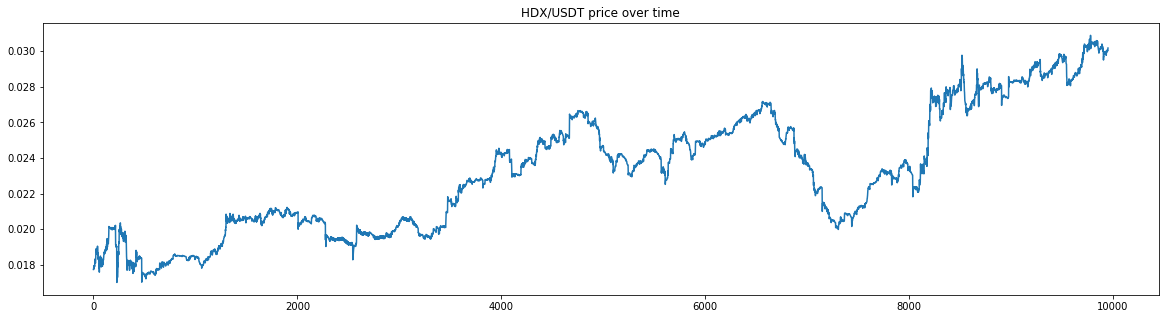

In [3]:
plt.figure(figsize=(20, 5))
plt.plot([line[1] for line in data])
plt.title('HDX/USDT price over time')

Text(0.5, 1.0, 'HDX/USDT buy/sell ratio over the same time period')

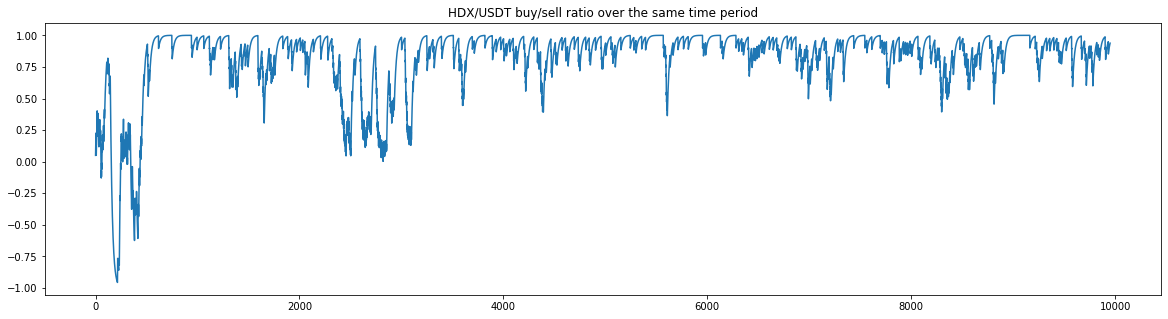

In [19]:
buy_sell_ratio = 0
ratio_trend = []
smooth_factor = 20
decay_factor = 1 / smooth_factor
for line in data:
    if line[3].startswith('buy'):
        buy_sell_ratio = buy_sell_ratio * (1 - decay_factor) + decay_factor
    else:
        buy_sell_ratio = buy_sell_ratio * (1 - decay_factor) - decay_factor
    ratio_trend.append(buy_sell_ratio)
plt.figure(figsize=(20, 5))
plt.plot(ratio_trend)
plt.title('HDX/USDT buy/sell ratio over the same time period')